# Detecting BDM In Superbowl Commercials

In [1]:
import pandas as pd
import os

In [2]:

%pip install -r requirements.txt

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
INDUSTRY_SPECIFIC_AWARENESS = False
BRAND_SPECIFIC_AWARENESS = False

# Donwload Ads


In [4]:
def download_videos():
# Define the URL and the target directory
  url = 'https://box.fu-berlin.de/s/zwxKp8PXkCwAwGe/download'
  download_filename = 'downloaded_archive.zip'
  target_directory = 'ADs'

  # Step 1: Download the file
  os.system(f'wget -O {download_filename} {url}')

  # Step 2: Create the target directory if it doesn't exist
  os.makedirs(target_directory, exist_ok=True)

  # Step 3: Extract the downloaded archive to the target directory
  os.system(f'unzip -o {download_filename} -d {target_directory}')

  # Step 4: Remove the downloaded file
  os.remove(download_filename)

  print(f"Archive extracted to {target_directory} and {download_filename} removed.")

# Comment in to download the videos
# download_videos()

# Merge Excel Files

In [5]:
BDM_excel = pd.read_excel('BDM.xlsx')
final_excel = pd.read_excel('previous_project_results.xlsx')

In [6]:
final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
).drop('BDM_old', axis=1, errors='ignore')


# print number of rows where BDM is NaN, 0 and 1
print(f"Number of rows where BDM is NaN: {final_excel[final_excel['BDM'].isna()].shape[0]}")
print(f"Number of rows where BDM is 0: {final_excel[final_excel['BDM'] == 0].shape[0]}")
print(f"Number of rows where BDM is 1: {final_excel[final_excel['BDM'] == 1].shape[0]}")


Number of rows where BDM is NaN: 22
Number of rows where BDM is 0: 411
Number of rows where BDM is 1: 139


In [7]:
ad_df = final_excel.groupby(['cont_primary_product_type', 'BRAND', 'AdNumber', "BDM"]).size().reset_index(name='count')
ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number'}, inplace=True)
ad_df.drop(columns=['count'], inplace=True)
ad_df.head(10)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


### Brand Keywords

In [8]:
if BRAND_SPECIFIC_AWARENESS:
    product_brand_df = pd.read_csv("product_brands.csv")

    product_brand_df['brand'] = product_brand_df['brand'].str.replace(' ', '').str.lower()
    ad_df['brand_clean'] = ad_df['brand'].str.replace(' ', '').str.lower()

    # Merge the dataframes
    ad_df = ad_df.merge(
        product_brand_df[['brand', 'product_brand_keywords']], 
        left_on='brand_clean',
        right_on='brand',
        how='left',
        suffixes=('', '_brand')
    )

    # Clean up columns
    ad_df.drop(['brand_clean', 'brand_brand'], axis=1, inplace=True)


    ad_df.head(10)

### Product Category Keywords

In [9]:
if INDUSTRY_SPECIFIC_AWARENESS:
    product_brands_df = pd.read_csv("product_categories.csv")
    product_brands_df.head(40)
    product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
    ad_df = ad_df.drop('product_category', axis=1)
    display(product_brands_df)
    display(ad_df)

    # Create a dictionary to map brands to their product categories and other attributes
    brand_to_info = {}
    for _, row in product_brands_df.iterrows():
        # Convert string representation of list to actual list
        brands = eval(row['product_cat_brands'])
        for brand in brands:
            # Remove spaces and convert to lowercase for more robust matching
            brand = brand.replace(' ', '').lower()
            # Store all columns for this brand
            brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

    # Function to find category info for a brand
    def find_brand_info(brand):
        # Clean brand name for matching
        clean_brand = brand.replace(' ', '').lower()
        return brand_to_info.get(clean_brand)

    # Add all product category columns to ad_df
    for col in product_brands_df.columns:
        ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

    # Print brands that couldn't be mapped
    unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
    if len(unmapped_brands) > 0:
        print("Brands without category mapping:")
        for brand in unmapped_brands:
            print(f"- {brand}")

    # Print number of rows with missing category
    print(f"Number of rows where product category is NaN: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")


    print(f"Final number of rows with missing categories: {ad_df[ad_df['product_cat_name'].isna()].shape[0]}")

    ad_df.head(10)

In [10]:
ad_df = ad_df.dropna()
# TODO: Implement proper handling of missing values
# TODO: Remove this line
if BRAND_SPECIFIC_AWARENESS or INDUSTRY_SPECIFIC_AWARENESS:
  ad_df = ad_df.head(5)
else:
  ad_df = ad_df.head(20)
display(ad_df)

# save progress so far to csv
# make csv dir if it doesn't exist
os.makedirs('csvs', exist_ok=True)
ad_df.to_csv('csvs/1_ad_df_baseline.csv', index=False)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


## Retrieving Transcript

In [11]:
ad_df = pd.read_csv('csvs/1_ad_df_baseline.csv')

In [12]:
import glob
from pathlib import Path
from transcript import transcribe_video

ads_dir = "ADs"

def find_video_file(commercial_number, ads_dir):
    """Find the video file path for a given commercial number."""
    # Search recursively for MP4 files
    pattern = f"{ads_dir}/**/{commercial_number}.mp4"
    matches = glob.glob(pattern, recursive=True)
    return matches[0] if matches else None

# Create transcript column
ad_df['transcript'] = ''

# Process each commercial
for idx, row in ad_df.iterrows():
    commercial_number = row['commercial_number']
    video_path = find_video_file(commercial_number, ads_dir)
    
    if video_path:
        transcript = transcribe_video(video_path)
        ad_df.at[idx, 'transcript'] = transcript
    else:
        print(f"Video not found for commercial {commercial_number}")

ad_df[ad_df['transcript'].notna()]
ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df.head(10)

/usr/local/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/lib

Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'


/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/pytho

Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Video not found for commercial AD0760
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'
Error transcribing video: [Errno 2] No such file or directory: 'ffmpeg'


/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.9/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/pytho

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,,
1,1.0,AvocadosfromMexico,AD0414,1.0,,
2,1.0,AvocadosfromMexico,AD0474,0.0,,
3,1.0,AvocadosfromMexico,AD0525,1.0,,
4,1.0,AvocadosfromMexico,AD0584,1.0,,
5,1.0,AvocadosfromMexico,AD0635,1.0,,
6,1.0,AvocadosfromMexico,AD0745,0.0,,
7,1.0,BUBLY,AD0586,1.0,,
8,1.0,Bai,AD0475,0.0,,
9,1.0,Butterfinger,AD0420,1.0,,


In [13]:

ad_df.to_csv('csvs/2_ad_df_transcript.csv', index=False)

## Adding OCR Text

In [14]:
ad_df = pd.read_csv('csvs/2_ad_df_transcript.csv')

In [15]:

# from ocr import ocr

In [16]:


ad_df['ocr_text'] = ''

ad_df.drop(columns=['ocr_text'], inplace=True)
for idx, row in ad_df.iterrows():
    transcript = row['transcript']

    ad_df.at[idx, 'ocr_text'] = 'NOT IMPLEMENTED YET'
    # TODO Uncomment the line below to run OCR on the transcript
    # ad_df.at[idx, 'ocr_text'] = ocr(transcript)

ad_df["audio_only_transcript"] = ad_df["transcript"]
ad_df['transcript'] = ad_df['ocr_text'] + ' ' + ad_df['transcript']
ad_df.head(10)


ad_df.to_csv('csvs/3_ad_df_ocr.csv', index=False)


In [17]:
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Determining Frequency of Superlatives and Comparative Adjectives

In [18]:

ad_df = pd.read_csv('csvs/3_ad_df_ocr.csv')

In [19]:
import spacy
import pandas as pd
from collections import Counter
import text_analysis as ta

# Create new columns to store the counts and percentages
ad_df['word_count'] = 0
ad_df['superlative_count'] = 0
ad_df['comparative_count'] = 0
ad_df['uniqueness_count'] = 0
ad_df['superlative_pct'] = 0.0
ad_df['comparative_pct'] = 0.0
ad_df['uniqueness_pct'] = 0.0
ad_df['total_bdm_terms_count'] = 0
ad_df['total_bdm_terms_pct'] = 0.0

# Process each row
for idx, row in ad_df.iterrows():
    word_count = len(ta.get_tokens(row['transcript']))
    ad_df.at[idx, 'word_count'] = word_count

    superlatives = ta.get_superlatives(row['transcript'])
    ad_df.at[idx, 'superlatives'] = ', '.join(superlatives) if superlatives else ''
    superlative_count = len(superlatives) if superlatives else 0
    ad_df.at[idx, 'superlative_count'] = superlative_count

    comparatives = ta.get_comparatives(row['transcript'])
    ad_df.at[idx, 'comparatives'] = ', '.join(comparatives) if comparatives else ''
    comparative_count = len(comparatives) if comparatives else 0
    ad_df.at[idx, 'comparative_count'] = comparative_count
    
    unique_words = ta.get_unique_words(row['transcript'])
    ad_df.at[idx, 'unique_words'] = ', '.join(unique_words) if unique_words else ''
    uniqueness_count = len(unique_words) if unique_words else 0
    ad_df.at[idx, 'uniqueness_count'] = uniqueness_count

    if word_count > 0:
        ad_df.at[idx, 'superlative_pct'] = superlative_count / word_count * 100
        ad_df.at[idx, 'comparative_pct'] = comparative_count / word_count * 100
        ad_df.at[idx, 'uniqueness_pct'] = uniqueness_count / word_count * 100
        
        total_bdm_terms = superlative_count + comparative_count + uniqueness_count
        ad_df.at[idx, 'total_bdm_terms_count'] = total_bdm_terms
        ad_df.at[idx, 'total_bdm_terms_pct'] = total_bdm_terms / word_count * 100

# Sort the DataFrame
ad_df = ad_df.sort_values(
    by=['superlative_count', 'comparative_count', 'superlative_pct', 'comparative_pct', 'uniqueness_pct'],
    ascending=[False, False, False, False, False]
)

# Display top 10 results
ad_df.head(10)

2025-01-18 18:10:40.643815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 18:10:40.650991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737223840.659248     565 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737223840.661724     565 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 18:10:40.671130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,superlative_pct,comparative_pct,uniqueness_pct,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0.0,0.0,0.0,0,0.0,,,


In [20]:
# remove superlatives, comparatives and unique_words from ad_df
ad_df.drop(columns=['comparative_pct', 'superlative_pct', 'uniqueness_pct'], inplace=True)
ad_df.head(10)


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,


## Nomen + Adjektive

In [21]:
# Apply the function to each transcript individually using pandas apply
ad_df["adj_noun_pairs"] = ad_df["transcript"].apply(ta.extract_adj_noun_pairs)

# Add a column for the number of adjective-noun pairs
ad_df["num_adj_noun_pairs"] = ad_df["adj_noun_pairs"].apply(len)

# Display the first 10 rows of the DataFrame
display(ad_df.head(10))

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,,,,[],0


In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict

nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [23]:
# Process each transcript
import numpy as np
if INDUSTRY_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_cat_keyword_similarities = {}
        for keyword in row['product_cat_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_cat_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_cat_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_cat_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_cat_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])
if BRAND_SPECIFIC_AWARENESS:
    for idx, row in ad_df.iterrows():
        transcript = row['transcript']
        product_brand_keyword_similarities = {}
        
        for keyword in row['product_brand_keywords'][1:-1].replace("'", "").split(", "):
            similarity = round(float(ta.get_semantic_similarity(transcript, keyword)), 3)
            product_brand_keyword_similarities[keyword] = similarity
        
        sorted_keywords = sorted(product_brand_keyword_similarities.items(), key=lambda x: x[1], reverse=True)
        top_3_keywords = sorted_keywords[:3]
        top_3_average = round(float(np.mean([sim for _, sim in top_3_keywords])), 3)
        
        print(f"\nTranscript {row['commercial_number']}:")
        print(f"Top 3 brand keywords:")
        for keyword, similarity in top_3_keywords:
            print(f"- {keyword}: {similarity}")
        print(f"Top 3 average brand similarity: {top_3_average}")
        
        ad_df.at[idx, 'product_brand_keyword_similarity'] = top_3_average
        ad_df.at[idx, 'product_brand_top_keywords'] = ', '.join([keyword for keyword, _ in top_3_keywords])

In [24]:

ad_df.to_csv('csvs/4_ad_df_keywords.csv', index=False)

In [25]:
import pandas as pd
ad_df = pd.read_csv('csvs/4_ad_df_keywords.csv')

In [26]:


ad_df[ad_df.isnull().any(axis=1)].head()
ad_df[ad_df.isna().any(axis=1)].head()

ad_df = ad_df[ad_df['transcript'] != '']
ad_df = ad_df[ad_df['transcript'] != '']

# print all from ad_df with empty values
display(ad_df[ad_df.isnull().any(axis=1)])
display(ad_df[ad_df.isna().any(axis=1)])

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


In [27]:
ad_df.head(20)

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


In [28]:
# Calculate the minimum number of samples in each group
# 
min_samples = min(len(ad_df[ad_df['BDM'] == 1]), len(ad_df[ad_df['BDM'] == 0]))
nn_df = ad_df
# Perform undersampling
ad_df_balanced = pd.concat([
    ad_df[ad_df['BDM'] == 1].sample(n=min_samples, random_state=42),
    ad_df[ad_df['BDM'] == 0].sample(n=min_samples, random_state=42)
]).reset_index(drop=True)

# Print the results
print(f"Total rows: {len(ad_df_balanced)}")
print(f"Rows with BDM = 1.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 1.0])}")
print(f"Rows with BDM = 0.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 0.0])}")



commercial_numbers = ad_df_balanced['commercial_number']

# TODO: remove the following line after testing
ad_df_balanced = ad_df

ad_df_balanced.head(20)

Total rows: 12
Rows with BDM = 1.0: 6
Rows with BDM = 0.0: 6


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


## Ansatz 1 (Machine learning)

In [29]:
# Print available columns
print("Available columns:")
print(ad_df_balanced.columns.tolist())

Available columns:
['product_category', 'brand', 'commercial_number', 'BDM', 'transcript', 'audio_only_transcript', 'ocr_text', 'word_count', 'superlative_count', 'comparative_count', 'uniqueness_count', 'total_bdm_terms_count', 'total_bdm_terms_pct', 'superlatives', 'comparatives', 'unique_words', 'adj_noun_pairs', 'num_adj_noun_pairs']


In [30]:

display(ad_df_balanced)


,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


In [31]:
ad_df_balanced.to_csv('csvs/5_ad_df_balanced.csv', index=False)

In [32]:
import pandas as pd
ad_df_balanced = pd.read_csv('csvs/5_ad_df_balanced.csv')


Tuning Logistic Regression...
Best parameters: {'C': np.float64(3.845401188473625), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.500

Tuning Decision Tree...
Best parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best score: 0.500

Tuning Random Forest...
Best parameters: {'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 156}
Best score: 0.500

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.12236203565420874), 'max_depth': 7, 'n_estimators': 64}
Best score: 0.500

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(7.5908023769472495), 'kernel': 'rbf'}
Best score: 0.500
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/majority_classifier.pkl
Saving Logistic Regression to t

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...
Evaluating AdaBoost...


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

,product_category,brand,commercial_number,BDM,transcript,audio_only_transcript,ocr_text,word_count,superlative_count,comparative_count,uniqueness_count,total_bdm_terms_count,total_bdm_terms_pct,superlatives,comparatives,unique_words,adj_noun_pairs,num_adj_noun_pairs
0,1.0,AvocadosfromMexico,AD0357,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
1,1.0,AvocadosfromMexico,AD0414,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
2,1.0,AvocadosfromMexico,AD0474,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
3,1.0,AvocadosfromMexico,AD0525,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
4,1.0,AvocadosfromMexico,AD0584,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
5,1.0,AvocadosfromMexico,AD0635,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
6,1.0,AvocadosfromMexico,AD0745,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
7,1.0,BUBLY,AD0586,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
8,1.0,Bai,AD0475,0.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0
9,1.0,Butterfinger,AD0420,1.0,NaN,NaN,NOT IMPLEMENTED YET,1,0,0,0,0,0.0,NaN,NaN,NaN,[],0


Cross-Validation Results:



| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Majority Classifier    |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| Logistic Regression    |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| Decision Tree          |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| Random Forest          |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| Gradient Boosting      |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| Support Vector Machine |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |
| K-Nearest Neighbors    |              0.5 |               0 |               0.3 |              0.1 |                0.3 |               0.1 |               1 |              0 |
| AdaBoost               |              0.5 |               0 |               0.7 |              0.1 |                0   |               0   |               0 |              0 |

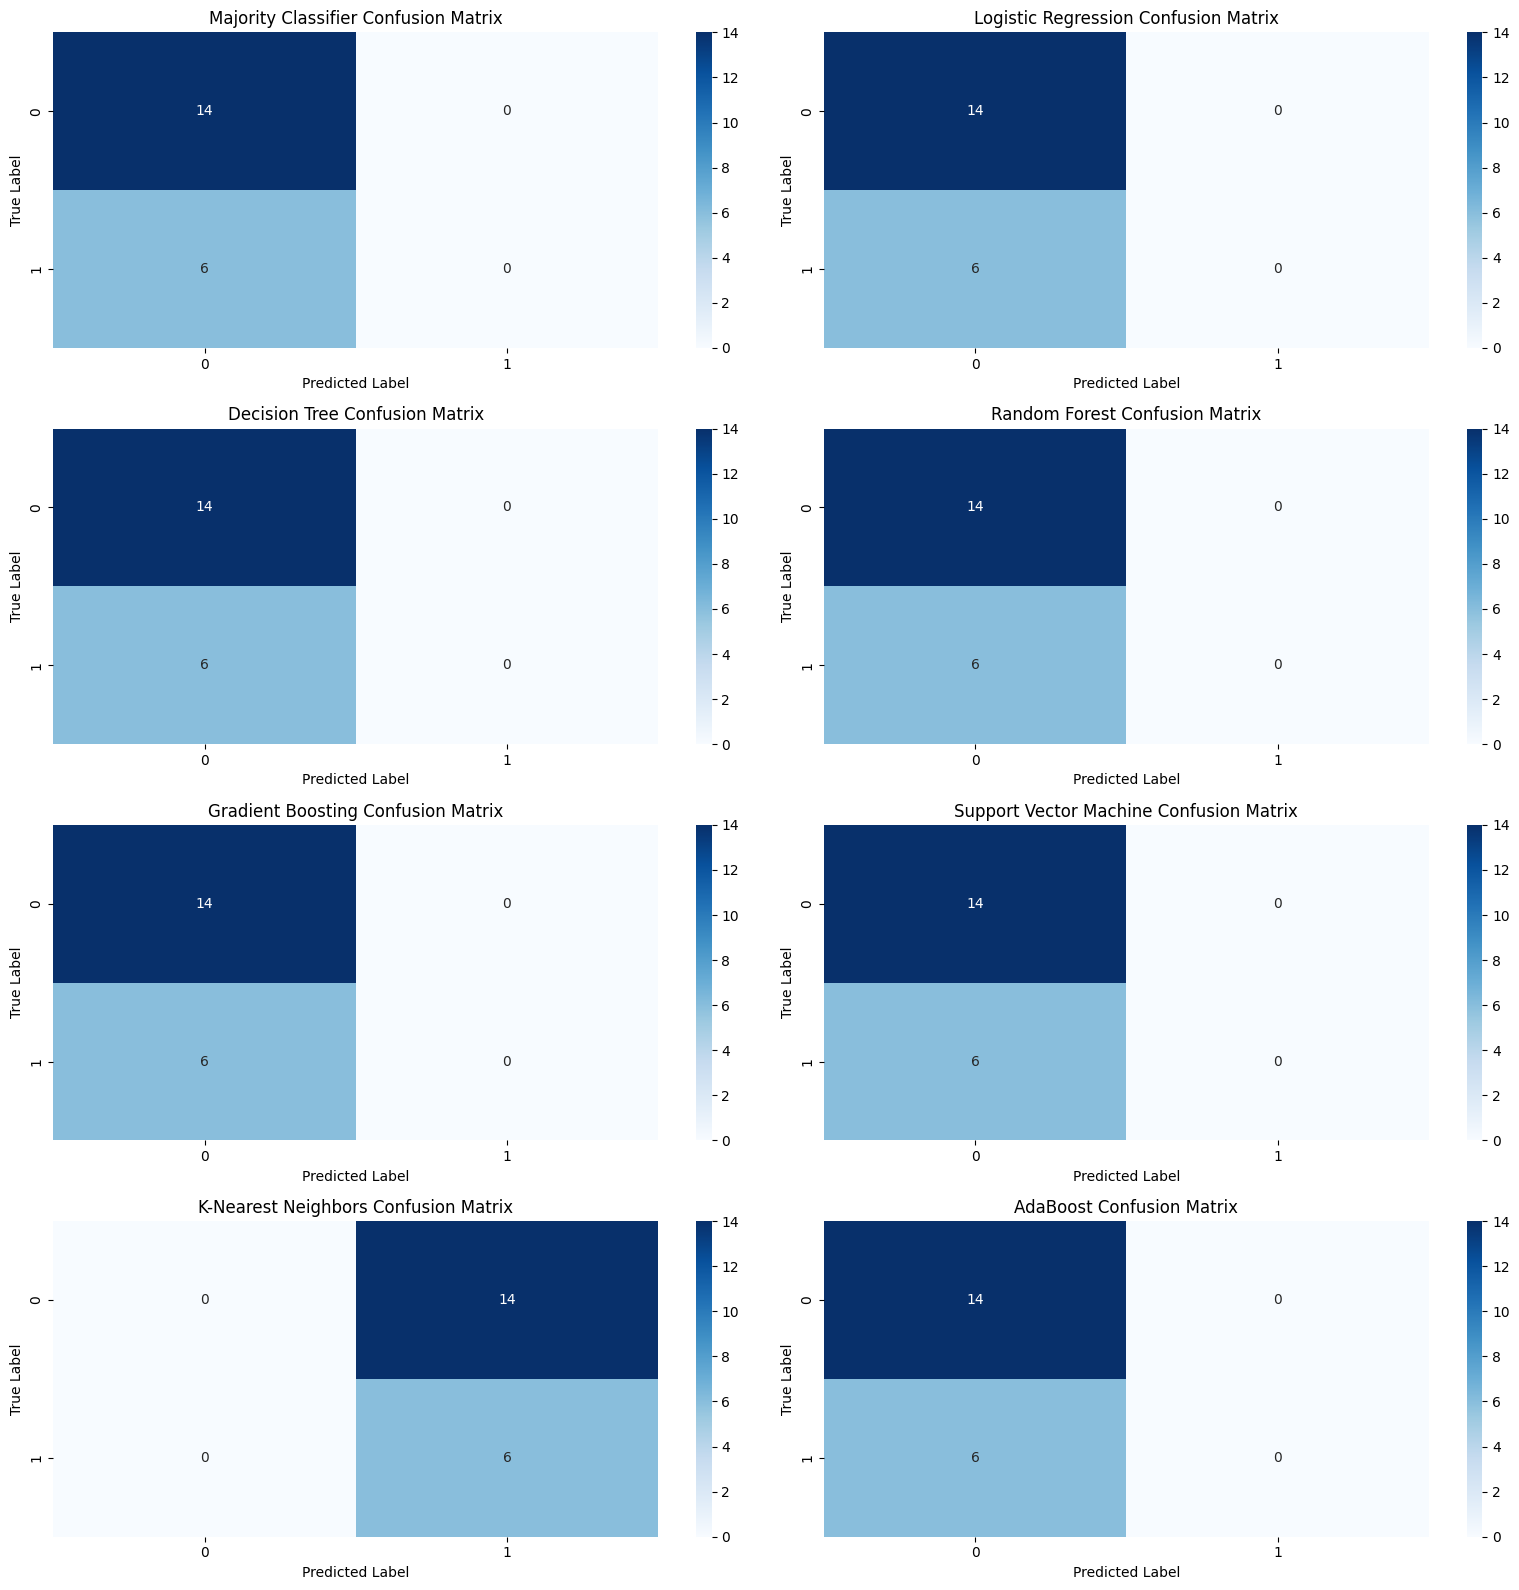

/tmp/ipykernel_565/426578484.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]


,commercial_number,commercial_number,BDM,Logistic Regression_result,Random Forest_result,Support Vector Machine_result,majority_vote
0,AD0357,AD0357,0.0,TN,TN,TN,TN
1,AD0414,AD0414,1.0,FN,FN,FN,FN
2,AD0474,AD0474,0.0,TN,TN,TN,TN
3,AD0525,AD0525,1.0,FN,FN,FN,FN
4,AD0584,AD0584,1.0,FN,FN,FN,FN
5,AD0635,AD0635,1.0,FN,FN,FN,FN
6,AD0745,AD0745,0.0,TN,TN,TN,TN
7,AD0586,AD0586,1.0,FN,FN,FN,FN
8,AD0475,AD0475,0.0,TN,TN,TN,TN
9,AD0420,AD0420,1.0,FN,FN,FN,FN



Decision Tree Analysis:


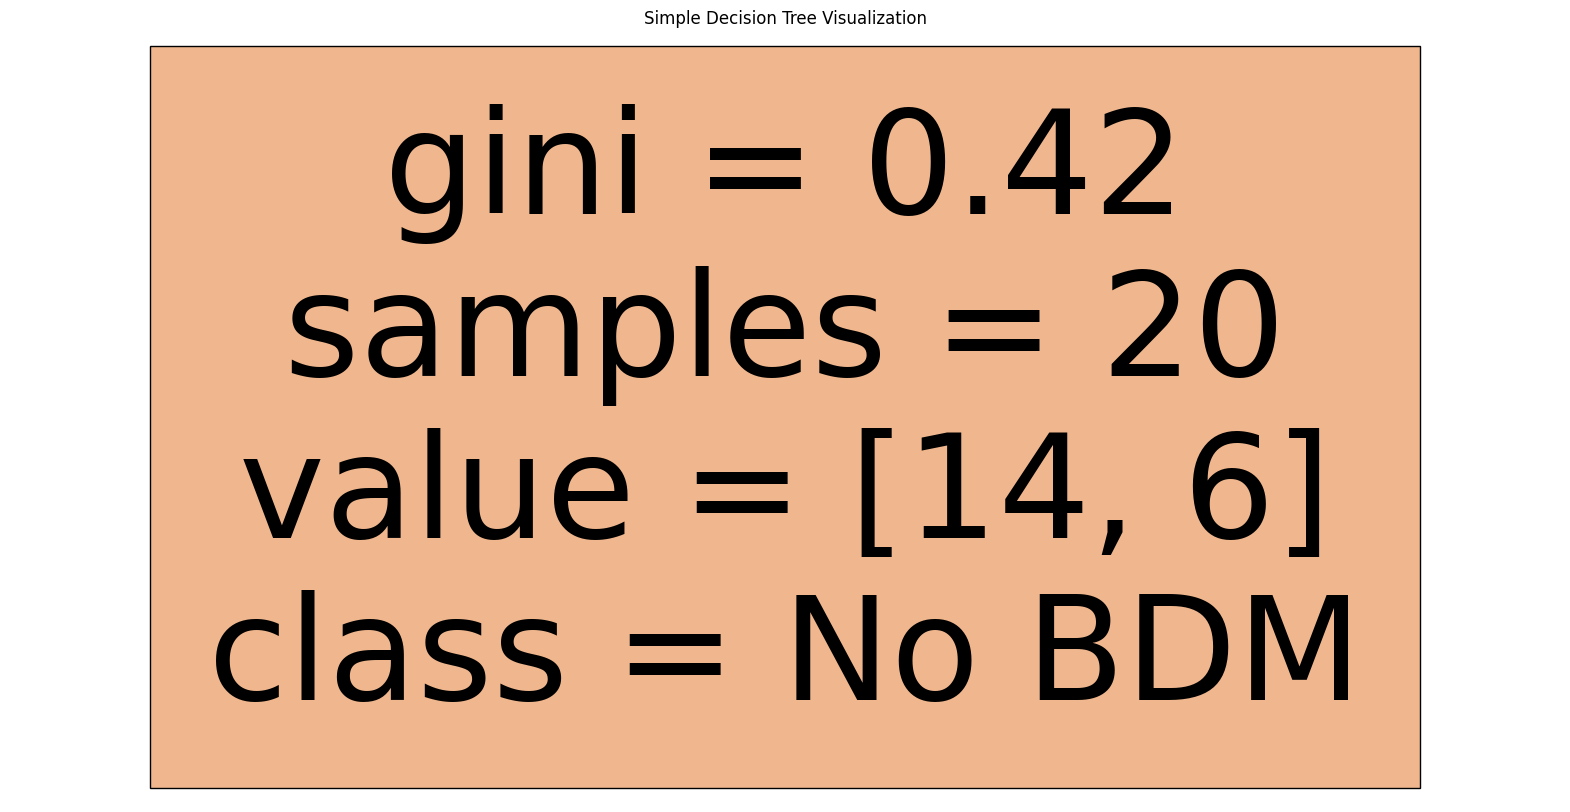


Feature Importance Ranking:
1. num_adj_noun_pairs: 0.000
2. total_bdm_terms_pct: 0.000
3. total_bdm_terms_count: 0.000
4. uniqueness_count: 0.000
5. comparative_count: 0.000
6. superlative_count: 0.000


In [33]:
import models as m

data, target = m.prepare_model_data(ad_df_balanced, INDUSTRY_SPECIFIC_AWARENESS, BRAND_SPECIFIC_AWARENESS)

base_models = m.get_base_models()
param_distributions = m.get_param_distributions()
tuned_models = m.tune_models(data, target, base_models, param_distributions)

trained_models = m.train_models(data, target, tuned_models)

# Evaluate the trained models
results_df, predictions = m.evaluate_models(data, target, trained_models)

original_data = ad_df_balanced.copy()
commercial_number = original_data['commercial_number']
display(original_data.head(10))

original_data = pd.concat([original_data, commercial_number], axis=1)

original_data = pd.concat([original_data, predictions], axis=1)

# After your existing model training code
m.display_model_results(data, target, trained_models, results_df)


predicted_data = original_data

# only include the top 3 models prediction results
predicted_data = predicted_data[['commercial_number', 'BDM', 'Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']]
# write the majority result of the colums logistic regression, random forest and support vector machine to a new column majority vote
predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]
display(predicted_data.head(10))


m.analyze_decision_tree(data, target, tuned_models)
